## Report: Geographically adapted betweenness centrality

**Course: Advanced Geoscripting 2023**  
**Authors: Gustav Schimmer & Philipp Friedrich**

### Research questions

Use the program you have written to generate different kinds of betweenness centrality indicators. Compare them with each other and answer the following questions in a new juputer notebook.

- Write one short paragraph for each question along with one or two suitable figures.
- No REPORT required!
- Cite relevant literature if applicable.
  
  
1. Calculate the betweenness centrality based on the shortest route and the one based on fastest route using the networkx package. Where are the biggest differences between them? Which one do you think is more realistic? Create figures to show your findings.
2. Calculate the geographically adapted betweenness centrality using your own implementation from the notebook several times with increasing number of routes. Compare the centrality index to the one calculated using the ox.edge_betweenness_centrality function from the networkx package. How does the difference between the two change with increasing number of routes? Create a figure to show this.
3. **Bonus**: Implement a function to choose the start and end nodes for the routes using the population data. Calculate the betweenness centrality based on this implementation and compare it with the betweenness centrality based on random start and endpoints. How do the resulting betweenness centrality indices differ?

Before we start we need to import all necessary packages.

In [46]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
ox.config(use_cache=True, log_console=True)

from betweenness_centrality.city_analyzer import CityAnalyzer
from betweenness_centrality.raster_analyzer import RasterAnalyzer

C:\Users\phili\AppData\Local\Temp\ipykernel_18872\2152801978.py:6: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


### 1. Betweenness centrality based on NetworkX using different route types

As example area the city of **Bremen, Germany** is used. First we need to download the OSM data for this city. For that we can use our own implementation and define a CityAnalyzer object for the city of Bremen. The OSM data is loaded automatically afterwards.

In [47]:
city = CityAnalyzer("Bremen, Germany")

We can now access and plot the graph of the city.

In [48]:
city.city_graph

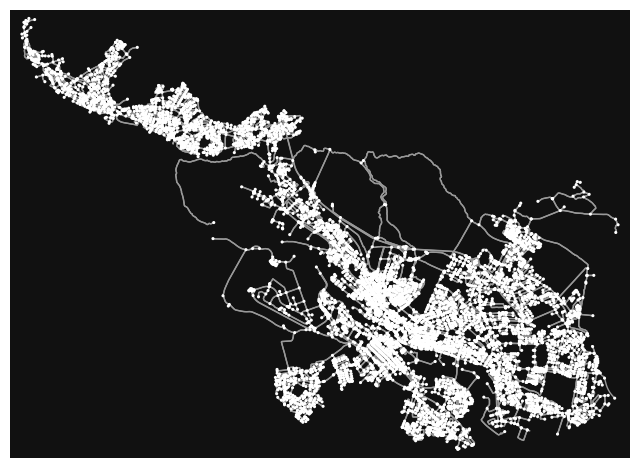

In [49]:
fig, ax = ox.plot_graph(city.city_graph, node_size=5)

After we loaded the data we can compute the NetworkX betweenness centrality and visualize it.

First we compute the centrality based on the shortest route.

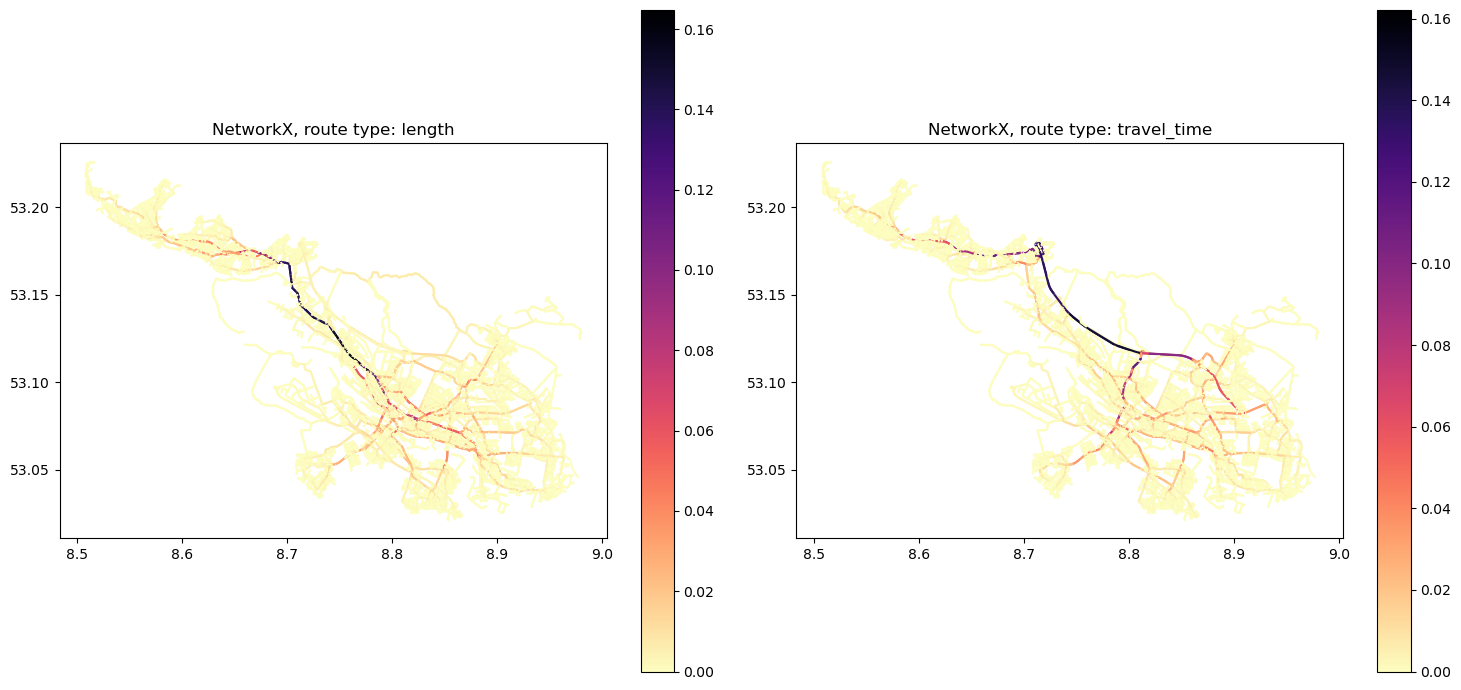

In [50]:
netcentrality_gdf_length = city.get_netcentrality("length")
netcentrality_gdf_time = city.get_netcentrality("travel_time")

# Plot the centrality
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot the centrality for "length"
netcentrality_gdf_length.plot(column="centrality", legend=True, cmap="magma_r", ax=axes[0])
axes[0].set_title("NetworkX, route type: length")

# Plot the centrality for "travel_time"
netcentrality_gdf_time.plot(column="centrality", legend=True, cmap="magma_r", ax=axes[1])
axes[1].set_title("NetworkX, route type: travel_time")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

The plots above show the NetworkX betweenness centrality for the city of Bremen based on the shortest routes (left) and the fastest routes (right). There are clearly some differences between the methods. Both aproaches make sense for different applications. If the shortest path is crucial, the shortest route option is appropriate. This might be the right approach, for example, for pedestrians and cyclists. On the other hand, the fastest connection, especially for motorized traffic, makes sense to reach the destination quickly, even if it's not the shortest route. This can be observed, for instance, on highways, which exhibit a high index in the fastest route map, while not having as much influence in the shortest route map. In this case, routes directly through the city are more prominently featured with a high centrality index.

### 2. Betweenness centrality based on own geographical approach

We can simply use our class object of the city of Bremen, to compute the geographically adapted betweenness centrality. As we want to calculate the centrality for different amounts of routes we can write a function for that.

In [51]:
def calc_geocentrality(city, num_routes, type):
    # Loading the polygon of the city
    city_poly = city.get_poly()
    
    # Sample random points in city area
    city_points = city.get_points(city_poly, num_routes * 2)

    # Create routes from random points
    city_routes = city.get_routes(city_points, num_routes, type)
    
    # Calculate geographically adapted centrality
    geocentrality_gdf = city.get_geocentrality(city_routes)

    return geocentrality_gdf

We can now execute the function for different amounts of routes. To keep the computation time low, we only use 10 and 100 routes as well as for the shortest and the fastest routes. Before we do so, we use StringIO to suppress print statements.

In [52]:
from io import StringIO
import sys

# Redirect stdout to capture print statements
original_stdout = sys.stdout
sys.stdout = StringIO()

Then we calculate the centrality for different route numbers and types ...

In [53]:
geocentrality_10_length = calc_geocentrality(city, 10, "length")
geocentrality_100_length = calc_geocentrality(city, 100, "length")
geocentrality_10_time = calc_geocentrality(city, 10, "travel_time")
geocentrality_100_time = calc_geocentrality(city, 100, "travel_time")

... and plot the results.

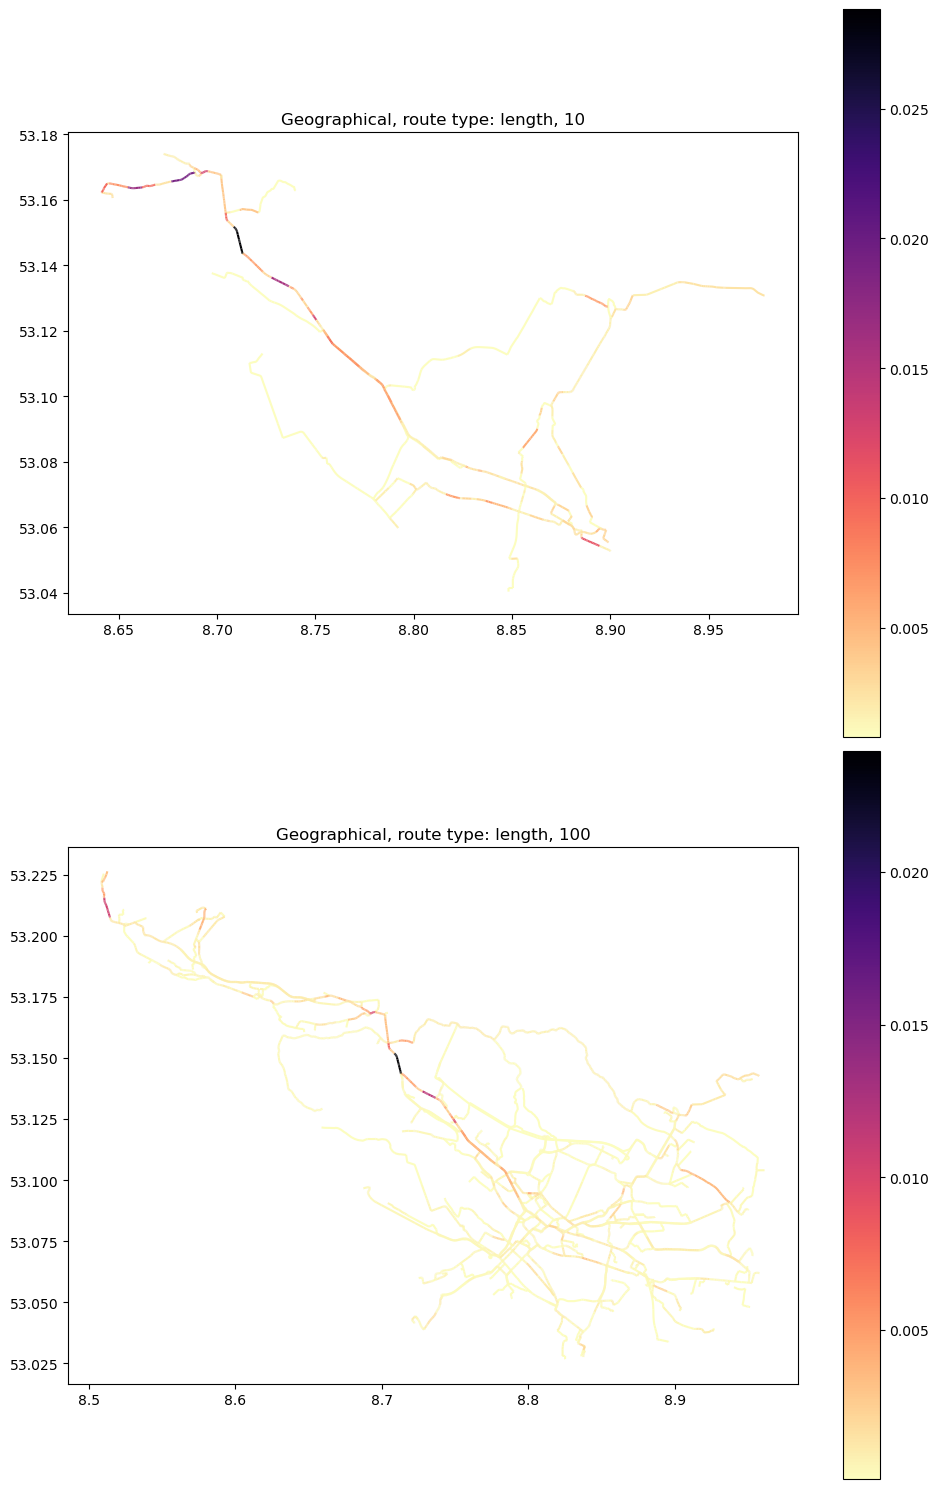

In [54]:
# Plot all routes below each other

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# 10 routes, length
geocentrality_10_length.plot(column="centrality", legend=True, cmap="magma_r", ax=axes[0])
axes[0].set_title("Geographical, route type: length, 10")

# 100 routes, length
geocentrality_100_length.plot(column="centrality", legend=True, cmap="magma_r", ax=axes[1])
axes[1].set_title("Geographical, route type: length, 100")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

As observed in the maps above, the outputs from the NetworkX package are more extensive than even with 5000 routes for the self-implemented geographical method (Image 1). This indicates that in the package, every node within the geographical boundaries contributes to the centrality calculation, unlike the custom method. In the custom method, only a subset of routes is calculated based on randomly selected points. Thus, the custom method may not be as informative even when up to 5000 routes are computed. Additionally, it is evident that the package is highly efficient, providing outputs in just a few seconds (even for larger areas like the city of Bremen), while the custom method is significantly slower and consumes more time and resources to achieve a similar result. It requires several minutes, especially when computing more than 1000 routes. Nevertheless the results of the custom method approach the results of the NetworkX package with increasing number of routes (Image 1). 

![Geographical bewteenness centrality](../img/allRoutesGeographical.png)

*Image 1: Compared visualization of geographical adapted betweenness centrality using different amounts of routes (own figure).*

### 3. **Bonus**: Betweenness centrality of population distribution based routes

As an additional approach we can choose the start and endpoints for the routes based on the population density in the city. Methods for this approach are implemented in the RasterAnalyzer class. For the calculation we need a GeoTiff raster containing information about the population density. First we specify the filepath to the raster.

In [55]:
raster_path = "../data/GHS_POP_WGS84.tif"

We can also write a function for several runs. 

In [56]:
def calc_geocentrality_pop(city, raster, num_routes, type):
    # Loading the polygon of the city
    city_poly = city.get_poly()
    
    # Sample random points in city area
    city_points = city.get_points(city_poly, num_routes * 4)

    # Sample raster values
    raster_points = raster.get_point_values(city_points)

    # Randomly select points weighted by raster 
    raster_points_weighted = raster.get_weighted_points(raster_points, num_routes * 2)

    # Create routes from random points
    city_routes = city.get_routes(raster_points_weighted, num_routes, type)
    
    # Calculate geographically adapted centrality
    geocentrality_gdf = city.get_geocentrality(city_routes)

    return geocentrality_gdf

Then we need to pass the raster filepath to our RasterAnalyzer object.

In [57]:
raster = RasterAnalyzer(raster_path)
raster.open()

<open DatasetReader name='../data/GHS_POP_WGS84.tif' mode='r'>

Afterwards we can execute the function to calculate the geographically adapted betweenness centrallity with population density based start and endpoints for the routes.

In [58]:
geocentrality_100_length_pop = calc_geocentrality_pop(city, raster, 100, "length")

Plot the centrality based on shortest routes with and without population density based start and endpoints.

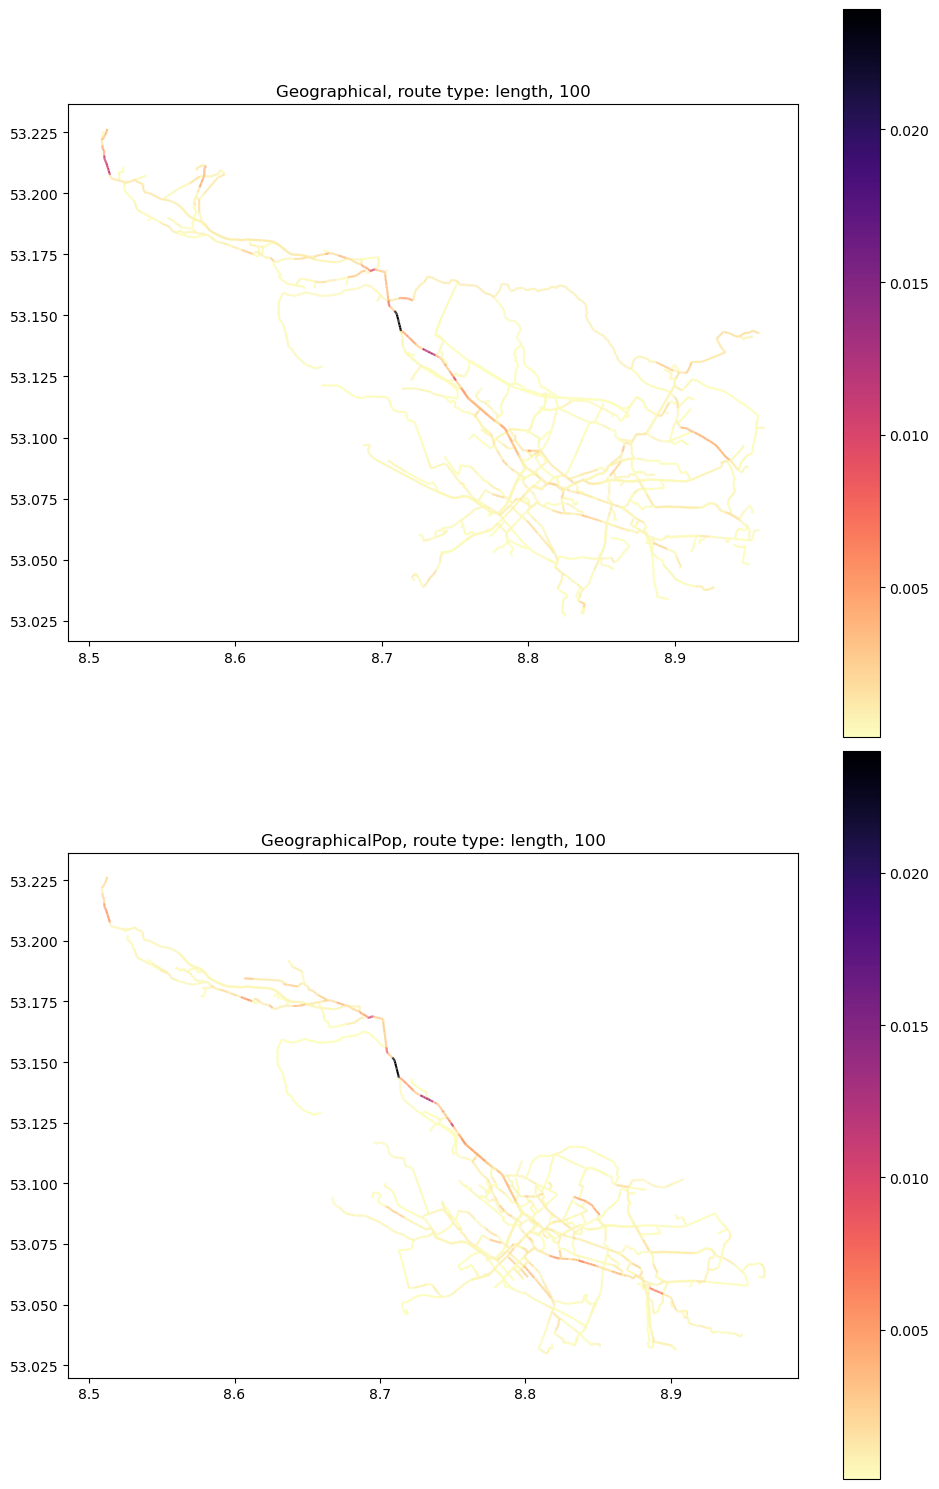

In [59]:
# Plot centrality based on shortest routes with and without population density based start and endpoints

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# 100 routes, geographical
geocentrality_100_length.plot(column="centrality", legend=True, cmap="magma_r", ax=axes[0])
axes[0].set_title("Geographical, route type: length, 100")

# 100 routes, 
geocentrality_100_length_pop.plot(column="centrality", legend=True, cmap="magma_r", ax=axes[1])
axes[1].set_title("GeographicalPop, route type: length, 100")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

For better visualization and less computation effort, we provided some maps created in QGIS (Image 2). These maps can be compared with the ones shown in Image 1. As evident in the displayed maps, the two methods yield different end results. Generally, roads connecting numerous areas with high population density (as indicated by the blue heatmap in the background) exhibit a higher centrality index in the method that incorporates population density, compared to the method that does not consider it. For instance, routes leading to industrial zones receive a higher index in the geographical method, assuming an equal population density as residential areas, which does not align with reality. In contrast, these routes to industrial zones receive a lower centrality index in the weighted population method, reflecting a more accurate representation of reality by considering the actual population distribution.

![Geographical bewteenness centrality population weighted](../img/allRoutesGeographicalPopulationWeighted.png)

*Image 2: Compared visualization of geographical adapted betweenness centrality using different amounts of routes and population density based start and endpoints for the routes (own figure).*